<a href="https://colab.research.google.com/github/rfmanz/pyutils/blob/main/Prueba_Validaci%C3%B3n_Interna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#sandbox = 'fper' 
#PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/'

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar -xvf spark-3.2.0-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"



# Prueba de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es predecir si un cliente en cuestión comprará el producto o no.



## Información sobre las variables del dataset

### Datos del cliente bancario
1. age
2. job: tipo de trabajo
3. marital: estado civil (nota: "divorced" implica tanto divorciado como viudo)
4. education
5. default: ¿no ha pagado alguna cuota de un crédito?
6. balance: saldo medio anual, en euros
7. housing: ¿tiene una hipoteca?
8. loan: ¿tiene un crédito?

### Relacionado con el último contacto con el cliente en la campaña actual
9. contact: tipo de comunicación del último contacto 
10. day: día de la fecha de último contacto
11. month: mes de la fecha de último contacto
12. duration: duración del último contacto, en segundos

### Otros atributos:
13. campaign: número de contactos llevados a cabo durante esta campaña y para este cliente (incluye el último contacto)
14. pdays: número de dias que han pasado desde que el cliente fue contactado por última vez durante la pasada campaña (-1 significa que el cliente no fue contactado)
15. previous: número de contactos que se han llevado a cabo antes de esta campaña y para este cliente 
16. poutcome: resultado de la última campaña de marketing

### Variable de salida (target):
17. y: ¿tiene el cliente contratado un depósito a plazo fijo?

In [ ]:
import findspark
findspark.init()

findspark.find()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Librerías:

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from pyspark.sql.types import StringType, DoubleType, IntegerType, ArrayType, DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

#Lectura de datos

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark import SQLContext
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sql = SQLContext(sc)

/content/spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


#Cargar data compartida

In [ ]:
bank_df = spark.read.csv('bank-full.csv', sep=';', header=True, inferSchema=True)

#Instrucciones
Se pide realizar las siguientes acciones, dejando la descripción del paso a paso que se sigue en cada punto solicitado:


*   Vista de los primeros 10 datos de la data cargada junto con mensajes que muestren el número de datos y de variables

*   Identificar las variables cualitativas y cuantitativas

*   Validar si hay registros duplicados

*   Obtener estadísticos de las variables

*   Evaluar valores perdidos en las variables y proponer que hacer con esos casos

*   Hacer un estudio de las variables categóricas encontradas en la data

*   Análisis de valores outliers en las variables y que se propone realizar con dichos casos

*   Proponer y aplicar tratamiento de variables para maximizar su contribución a los modelos propuestos

*   Análisis Bivariante con respecto a la variable target

*   Proponer dos modelos, justificando su uso, presentado sus principales métricas, así como los supuestos aplicados y limitaciones

*   Colocar los resultados y conclusiones en una ppt

*   El entregable final es la ppt y el notebook


Suerte!!














In [ ]:
bank_df.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [ ]:
print((bank_df.count(), len(bank_df.columns)))

(45211, 17)


In [ ]:
bank_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [ ]:
if bank_df.count() > bank_df.dropDuplicates(bank_df.columns).count():
    raise ValueError('Data has duplicates')
else:
  print('Data has no duplicates')

Data has no duplicates


In [ ]:
bank_df.summary().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+-----------------+-----+------------------+-----------------+------------------+------------------+--------+-----+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|              day|month|          duration|         campaign|             pdays|          previous|poutcome|    y|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+-----------------+-----+------------------+-----------------+------------------+------------------+--------+-----+
|  count|             45211|  45211|   45211|    45211|  45211|             45211|  45211|45211|   45211|            45211|45211|             45211|            45211|             45211|             45211|   45211|45211|
|   mean| 40.93621021432837|   null|    null|     null|   null|1362.2720576850766|   null| null|    null|15.806418791886

In [ ]:
print("Unknown/Nulls:")
print()
print( 'job',  bank_df.where(bank_df.job.like('unknown')).count())
print('education', bank_df.where(bank_df.education.like('unknown')).count())
print('contact', bank_df.where(bank_df.contact.like('unknown')).count())
print('poutcome', bank_df.where(bank_df.poutcome.like('unknown')).count())


Unknown/Nulls:

job 288
education 1857
contact 13020
poutcome 36959


Valores nulos :
- Considerarlos como otra categoría
- Imputar usando promedio or mediana 
- Imputar usando metodologías mas avanzadas por ejemplo: 

https://github.com/AnotherSamWilson/miceforest

In [ ]:
def ordered_barplot_h(df, variable_name, rotate=0):
    s = df[~pd.isnull(df[[variable_name]])][variable_name]
    chart = pd.value_counts(s).to_frame(name='data')
    chart.index.name = 'labels'
    chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(y="labels", x="data", data=chart)
    ncount = len(df[[variable_name]])
    # plt.title('Distribution of Truck Configurations')
    # ax.set_xticklabels(labels=tr.state, rotation=90)

    plt.xticks(rotation=rotate)

    # # Switch so count axis is on right, frequency on left
    ax.yaxis.tick_left()
    # ax2.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    # ax2.yaxis.set_label_position('left')

    # ax.set_ylabel('%', rotation=180, fontsize=10, va='bottom', ha='right')
    ax.set_ylabel("")

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_width() / ncount * 100)
        width, height = p.get_width(), p.get_height()
        x = p.get_x() + width + 0.02
        y = p.get_y() + height / 2
        ax.annotate(percentage, (x, y), ha='left', va='center')

    return plt.show()

In [ ]:
def ordered_barplot(df, variable_name, rotate=0):
    s = df[~pd.isnull(df[[variable_name]])][variable_name]
    chart = pd.value_counts(s).to_frame(name='data')
    chart.index.name = 'labels'
    chart = chart.reset_index().sort_values(['data', 'labels'], ascending=[False, True])
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="labels", y="data", data=chart)
    ncount = len(df[[variable_name]])
    # plt.title('Distribution of Truck Configurations')
    # ax.set_xticklabels(labels=tr.state, rotation=90)
    plt.xlabel(variable_name)
    plt.xticks(rotation=rotate)

    # Make twin axis
    ax2 = ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.1f}%'.format(100. * y / ncount), (x.mean(), y), ha='center',
                    va='bottom')  # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0, 100)
    ax.set_ylim(0, ncount)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    ax2.grid(False)

    return plt.show()

In [ ]:
def box_plot_classification(df, target_name):
    df[target_name] = df[target_name].astype('object')
    continuous_cols = list(df.select_dtypes("number").columns)
    data = pd.DataFrame(StandardScaler().fit_transform(df[continuous_cols]), columns=df[continuous_cols].columns,
                        index=df[continuous_cols].index)
    data = pd.concat([data, df[[target_name]]], axis=1)
    data = pd.melt(data, id_vars=target_name,
                   var_name="features",
                   value_name='value')

    plt.figure(figsize=(10, 10))
    ax = sns.boxplot(x="features", y="value", hue=target_name, data=data)
    for i in range(len(np.unique(data["features"])) - 1):
        ax.axvline(i + 0.5, color='grey', lw=1)
    plt.xticks(rotation=20)
    return plt.show()

In [ ]:
bank_df_pandas = bank_df.toPandas()

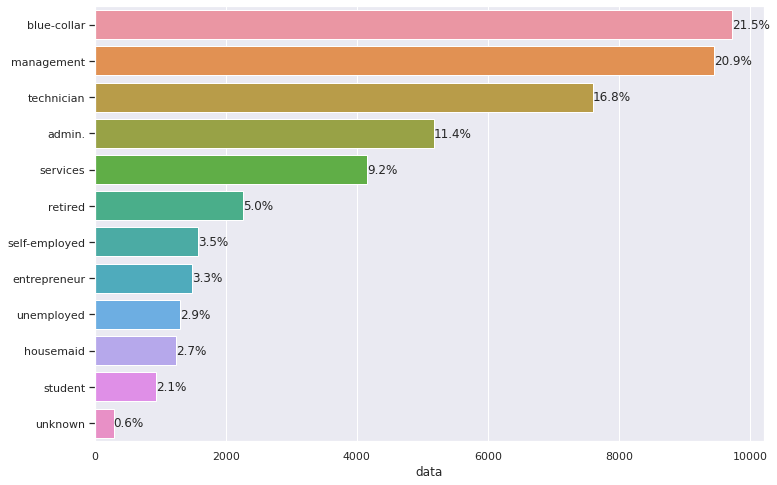

In [ ]:
ordered_barplot_h(bank_df_pandas, "job")

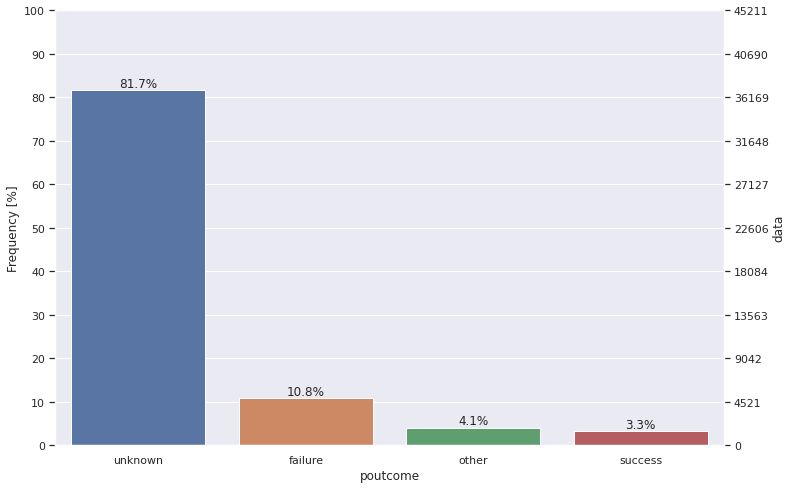

In [ ]:
import matplotlib.ticker as ticker
ordered_barplot(bank_df_pandas, "poutcome")

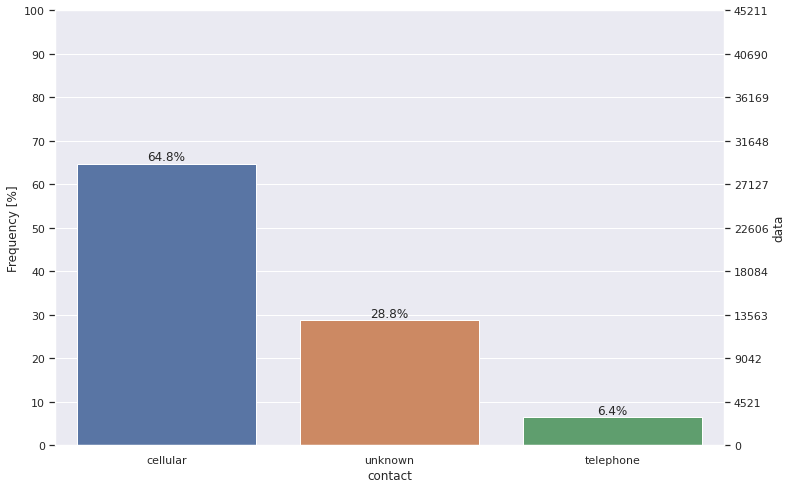

In [ ]:
ordered_barplot(bank_df_pandas, "contact")

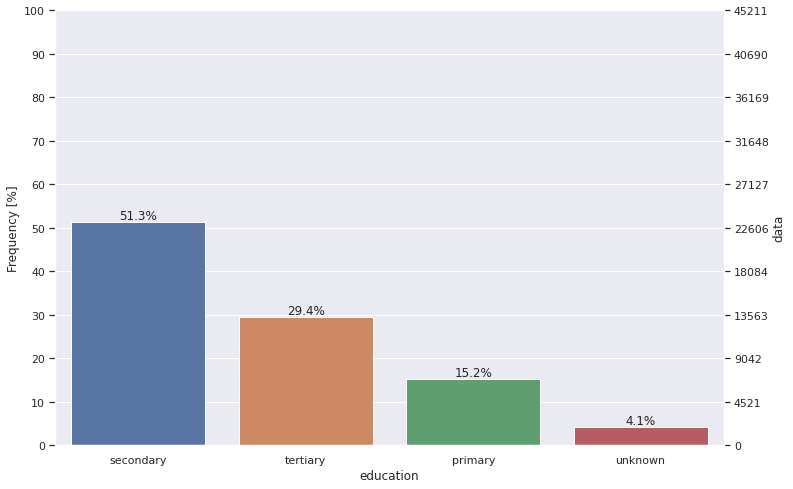

In [ ]:
ordered_barplot(bank_df_pandas, "education")

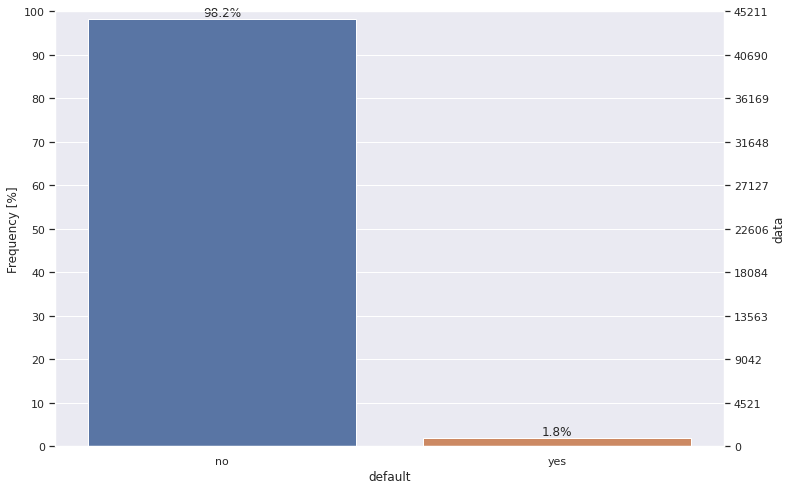

In [ ]:
ordered_barplot(bank_df_pandas, "default")

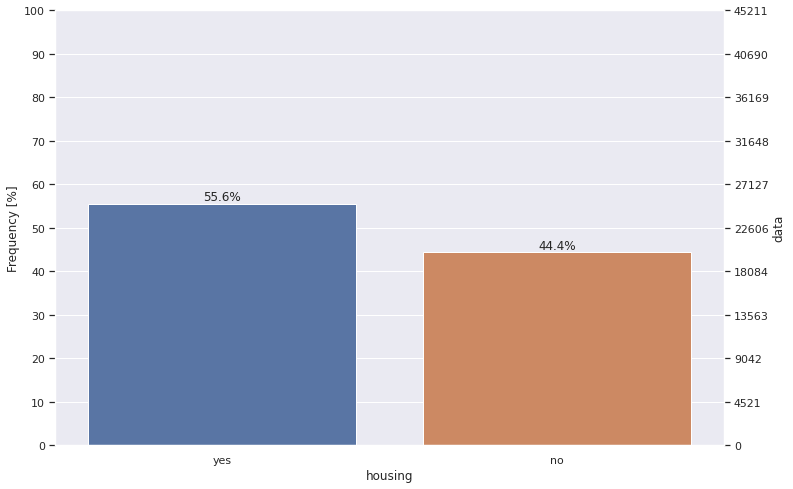

In [ ]:
ordered_barplot(bank_df_pandas, "housing")

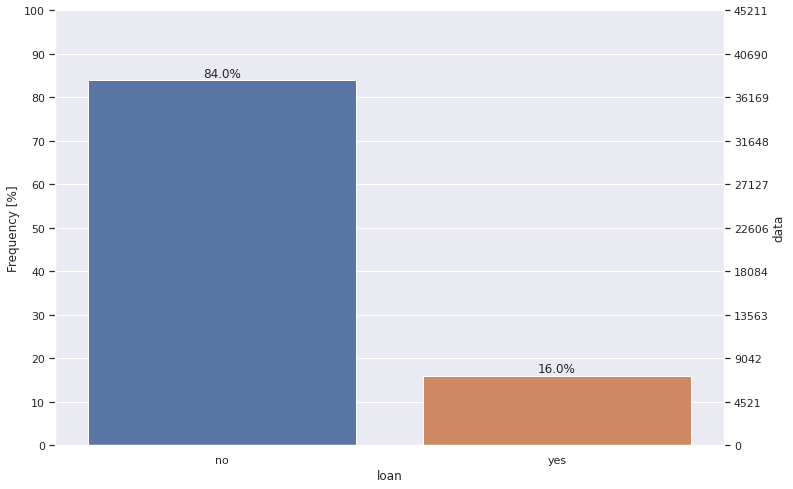

In [ ]:
ordered_barplot(bank_df_pandas, "loan")

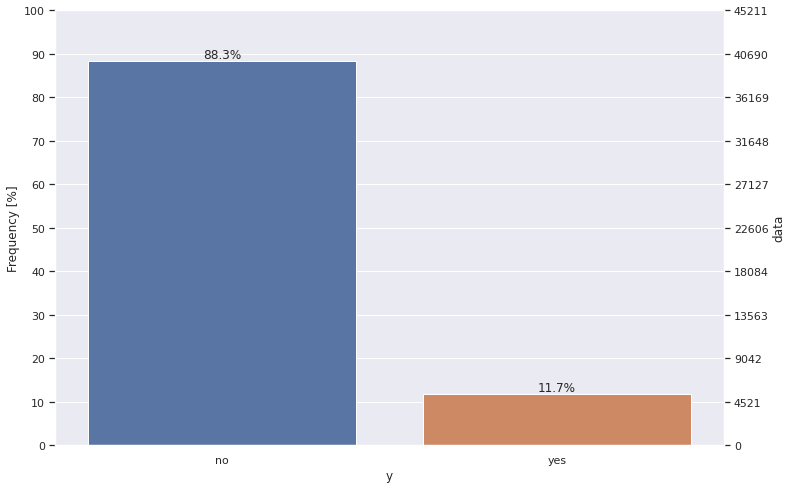

In [ ]:
ordered_barplot(bank_df_pandas, "y")

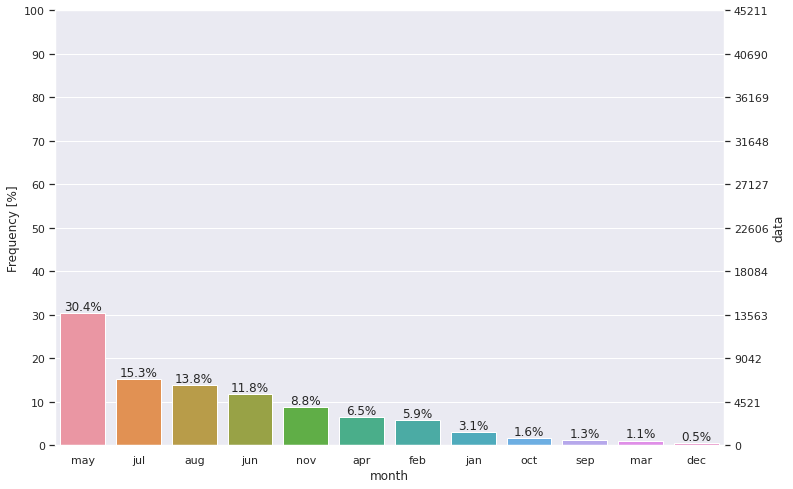

In [ ]:
ordered_barplot(bank_df_pandas, "month")

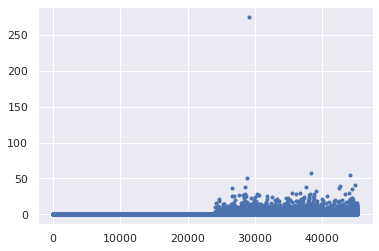

In [ ]:
bank_df_pandas.previous.plot(style='.')

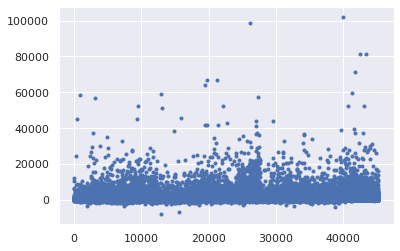

In [ ]:
bank_df_pandas.balance.plot(style='.')

Outliers:

* Remover
* Min max scaling 
* Standardization 

In [ ]:
bank_df_pandas.drop(bank_df_pandas[bank_df_pandas.previous > 42].index, inplace=True)


In [ ]:
bank_df_pandas.drop(bank_df_pandas[bank_df_pandas.balance > 60000].index, inplace=True)


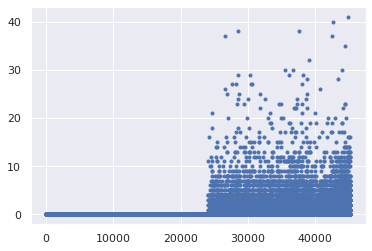

In [ ]:
bank_df_pandas.previous.plot(style='.')

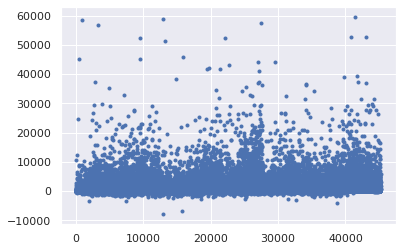

In [ ]:
bank_df_pandas.balance.plot(style='.')

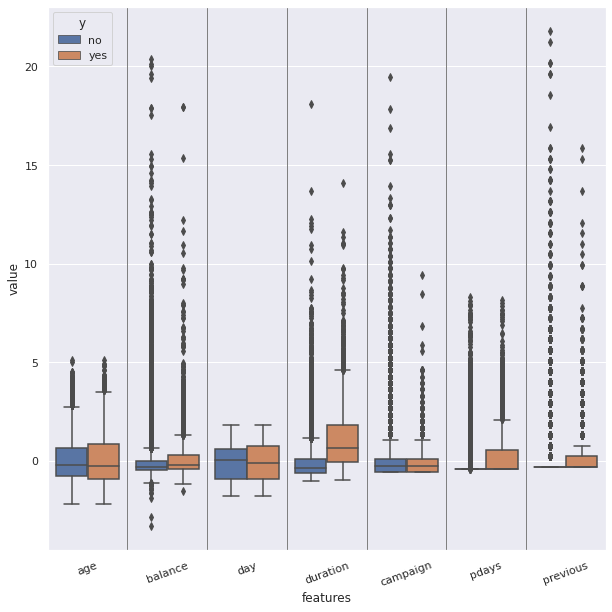

In [ ]:
from sklearn.preprocessing import StandardScaler
box_plot_classification(bank_df_pandas, "y")

In [ ]:
def encode(df, method="dmy"):
    """ methods:
        Dummy encoding = pandas get_dummies
        Label encoding = sklearn LabelEncoders
    """
    cols = df.select_dtypes('object').columns

    if method == "lbl":
        for i in cols:
            df[i] = LabelEncoder().fit_transform(df[i].astype(str))
        return df

    if method == "dmy":
        encoded = pd.get_dummies(df[cols])
        df = df.drop(columns=cols, axis=1)
        df = pd.concat([df, encoded], axis=1)
        return df

In [ ]:
bank_df_pandas.dtypes

age           int32
job          object
marital      object
education    object
default      object
balance       int32
housing      object
loan         object
contact      object
day           int32
month        object
duration      int32
campaign      int32
pdays         int32
previous      int32
poutcome     object
y            object
dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder
bank_df_pandas_lbl = encode(bank_df_pandas,'lbl')

In [ ]:
bank_df_pandas_lbl.dtypes

age          int32
job          int64
marital      int64
education    int64
default      int64
balance      int32
housing      int64
loan         int64
contact      int64
day          int32
month        int64
duration     int32
campaign     int32
pdays        int32
previous     int32
poutcome     int64
y            int64
dtype: object

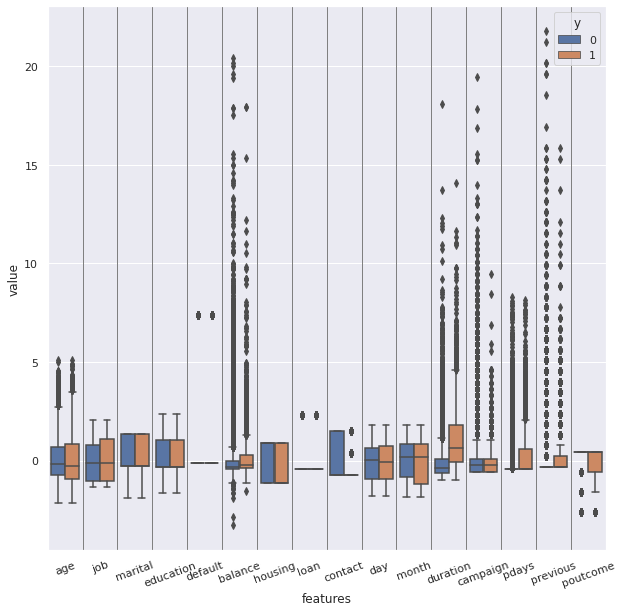

In [ ]:
from sklearn.preprocessing import StandardScaler
box_plot_classification(bank_df_pandas, "y")

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from pyspark.sql.types import StringType, DoubleType, IntegerType, ArrayType, DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

•   Identificar variables altamente correlacionadas

•   Label encoding/ One hot encoding 

•   Consolidar variables day & month 

  Binning de variables edades & saldos

In [ ]:
def correlated(df, threshold, drop_columns=False, encode_type='dmy'):
    '''Create a copy if you're viewing before deleting.
    If deleting df= correlated(df,...)'''
    df = df.copy()
    if bool((df.select_dtypes('object')).size > 0):
        df = encode(df, encode_type)
        df_corr = df.corr()

    else:
        df_corr = df.corr()

    triangle = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
    to_drop = pd.Series(df_corr.iloc[:,
                        np.where((df_corr.mask(np.tril(np.ones(df_corr.shape, dtype=bool))).abs() > threshold).any())[
                            0]].columns)

    if drop_columns:
        df = df.drop(labels=to_drop, axis=1)
        return df


    else:

        collinear = pd.DataFrame(columns=['drop_feature', 'corr_feature', 'corr_value'])

        for i in to_drop:

            # Find the correlated features
            corr_features = list(triangle.index[triangle[i].abs() > threshold])

            # Find the correlated values
            corr_values = list(triangle[i][triangle[i].abs() > threshold])
            drop_features = [i for _ in range(len(corr_features))]

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                              'corr_feature': corr_features,
                                              'corr_value': corr_values})
            # Add to dataframe
            collinear = collinear.append(temp_df, ignore_index=True)


        else:
            print(f"From {len(df.columns)} columns")
            print(f"{len(to_drop)} highly correlated columns to drop:")
            print()
            print(to_drop)
            print("-----")
            print(
                "Note_to_self...drop_feature may be duplicated due to multiple, stronger than threshold, correlated pairs:")
            print()
            print(collinear)

In [ ]:
correlated(bank_df_pandas, 0.85,encode_type='lbl')

From 17 columns
1 highly correlated columns to drop:

0    poutcome
dtype: object
-----
Note_to_self...drop_feature may be duplicated due to multiple, stronger than threshold, correlated pairs:

  drop_feature corr_feature  corr_value
0     poutcome        pdays   -0.858497


In [ ]:
bank_df.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [ ]:
bank_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [ ]:
 columnList = [item[0] for item in bank_df.dtypes if item[1].startswith('string')]
 columnList

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [ ]:
for variable in columnList:
    #converts string variables to numerical indices e.g. January to 1, February to 2 etc.
    indexer = StringIndexer(inputCol=variable, outputCol=variable+"index")
    logisticdata = indexer.fit(bank_df).transform(bank_df)
    
    #explodes the now numerical categorical variables into binary variables 
    encoder = OneHotEncoder(inputCol=variable+"index", outputCol=variable+"vec")
    logisticdata = encoder.fit(logisticdata).transform(logisticdata)  

In [ ]:
logisticdata.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------+-------------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|yindex|         yvec|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------+-------------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|   0.0|(1,[0],[1.0])|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|   0.0|(1,[0],[1.0])|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|   0.0|(1,[0],[1.0])|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|    

In [ ]:
logisticdata_pandas = logisticdata.toPandas()

In [ ]:
logisticdata_pandas.yindex.value_counts()

0.0    39922
1.0     5289
Name: yindex, dtype: int64

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

columnList = [item[0] for item in bank_df.dtypes if item[1].startswith('string')]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in columnList]

pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(bank_df).transform(bank_df)

df_r.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|y_index|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|      1.0|          0.0|            1.0|          0.0|          0.0|       0.0|          1.0|

Value_counts equivalent:

In [ ]:
df_r.groupBy('month_index').count().orderBy('count',ascending=False).show()

+-----------+-----+
|month_index|count|
+-----------+-----+
|        0.0|13766|
|        1.0| 6895|
|        2.0| 6247|
|        3.0| 5341|
|        4.0| 3970|
|        5.0| 2932|
|        6.0| 2649|
|        7.0| 1403|
|        8.0|  738|
|        9.0|  579|
|       10.0|  477|
|       11.0|  214|
+-----------+-----+



Mapping between label encoded & values 

In [ ]:
df_r.select('month','month_index').distinct().show()

+-----+-----------+
|month|month_index|
+-----+-----------+
|  jul|        1.0|
|  jan|        7.0|
|  apr|        5.0|
|  sep|        9.0|
|  mar|       10.0|
|  dec|       11.0|
|  oct|        8.0|
|  nov|        4.0|
|  aug|        2.0|
|  jun|        3.0|
|  feb|        6.0|
|  may|        0.0|
+-----+-----------+



In [ ]:
df_r.select('month','month_index').distinct().orderBy('month_index',ascending=False).show()

+-----+-----------+
|month|month_index|
+-----+-----------+
|  dec|       11.0|
|  mar|       10.0|
|  sep|        9.0|
|  oct|        8.0|
|  jan|        7.0|
|  feb|        6.0|
|  apr|        5.0|
|  nov|        4.0|
|  jun|        3.0|
|  aug|        2.0|
|  jul|        1.0|
|  may|        0.0|
+-----+-----------+



Select all columns of type x 

In [ ]:
columnList = [item[0] for item in df_r.dtypes if item[1].startswith('double')]
columnList

['job_index',
 'marital_index',
 'education_index',
 'default_index',
 'housing_index',
 'loan_index',
 'contact_index',
 'month_index',
 'poutcome_index',
 'y_index']

Cast multiple columns to desired type

In [ ]:
from pyspark.sql.functions import *
for c in columnList:
  df_r = df_r.withColumn(c, col(c).cast('integer'))

In [ ]:
df_r.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- job_index: integer (nullable = true)
 |-- marital_index: integer (nullable = true)
 |-- education_index: integer (nullable = true)
 |-- default_index: integer (nullable = true)
 |-- housing_index: integer (nullable = true)
 |-- loan_index: integer (nullable = true)
 |-- contact_index: integer (nullable = true)
 |-- month_index: integer (

In [ ]:
df_r = df_r.withColumn("day_month",concat(col('day'),lit(""),col('month_index')))

In [ ]:
# Buckets: 
# from pyspark.ml.feature import Bucketizer
# bucketizer = Bucketizer(splits=[ -8020, 0, 272, 701,12200, float('Inf') ],inputCol="balance", outputCol="balance_bins")
# df_r = bucketizer.setHandleInvalid("keep").transform(df_r)

Drop columns

In [ ]:
df_r = df_r.drop('balance_bins2')
# Drop multiple columns
# columns_to_drop = ['id', 'id_copy']
# df = df.drop(*columns_to_drop)

In [ ]:
# Quantiles: 
from pyspark.ml.feature import QuantileDiscretizer
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="balance", outputCol="balance_binned", relativeError=0.01, handleInvalid="error")
df_r = discretizer.setHandleInvalid("keep").fit(df_r).transform(df_r)

In [ ]:
df_r.groupBy('balance_binned').count().orderBy('count',ascending=False).show()

+--------------+-----+
|balance_binned|count|
+--------------+-----+
|           4.0| 9478|
|           1.0| 9226|
|           3.0| 9020|
|           2.0| 8882|
|           0.0| 8605|
+--------------+-----+



In [ ]:
#Check ranges 
df_r.groupby('balance_binned').agg(min('balance'), max('balance')).orderBy('balance_binned', ascending =True).show()


+--------------+------------+------------+
|balance_binned|min(balance)|max(balance)|
+--------------+------------+------------+
|           0.0|       -8019|          14|
|           1.0|          15|         262|
|           2.0|         263|         675|
|           3.0|         676|        1777|
|           4.0|        1778|      102127|
+--------------+------------+------------+



Min Max Scaler

In [ ]:
columns_to_scale = ["balance", "previous"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(df_r)
scaledData = scalerModel.transform(df_r)

In [ ]:
scaledData.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+---------+--------------+-----------+------------+--------------------+---------------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|y_index|day_month|balance_binned|balance_vec|previous_vec|      balance_scaled|previous_scaled|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+---------+--------------+-----------+------------+

Pipeline
edit: too much overhead. do manually

In [ ]:
# #indexer(label encoding)
# columnList = [item[0] for item in bank_df.dtypes if item[1].startswith('string')]
# indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in columnList]

# #binning
# discretizer = QuantileDiscretizer(numBuckets=5, inputCol="balance", outputCol="balance_binned", relativeError=0.01, handleInvalid="error")

# #min max scaler
# columns_to_scale = ["balance", "previous"]
# assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
# scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]

# #pipeline stages 
# stages = indexers
# stages.append(discretizer)
# stages.append([assemblers, scalers])
# pipeline = Pipeline().setStages(stages)

# #pipeline fit_transform
# df_r_fitted = pipeline.fit(bank_df)
# #df_r= df_r_fitted.transform()

# #concat
# df_r = df_r.withColumn("day_month",concat(col('day'),lit(""),col('month_index')))
# df_r.show()

In [ ]:
#pipeline = Pipeline().setStages(indexers ,discretizer , [assemblers,scalers])

Full

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import RobustScaler
from pyspark.sql.functions import *


bank_df = spark.read.csv('bank-full.csv', sep=';', header=True, inferSchema=True)


#indexer(label encoding)
columnList_strings = [item[0] for item in bank_df.dtypes if item[1].startswith('string')]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in columnList_strings]

pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(bank_df).transform(bank_df)

#outliers
df_r= df_r.filter(df_r["previous"]<42)
df_r= df_r.filter(df_r["balance"]<60000)
#df_r= df_r.filter(df_r["campaign"]<48)


#binning
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="campaign", outputCol="campaign_binned", relativeError=0.01, handleInvalid="error")
df_r = discretizer.setHandleInvalid("keep").fit(df_r).transform(df_r)


#scaling
#columns_to_scale = ["balance", "previous"]
columns_to_scale1 = ["balance"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
#min_max scaling
#scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]

#robust scaler
scalers = [RobustScaler(inputCol=col + "_vec", outputCol=col + "_scaled", withScaling=True, withCentering=False,
                      lower=0.25, upper=0.75) for col in columns_to_scale1]
pipeline = Pipeline(stages=assemblers + scalers)
df_r = pipeline.fit(df_r).transform(df_r)


#to_integer
columnList_double = [item[0] for item in df_r.dtypes if item[1].startswith('double')]
for c in columnList_double:
  df_r = df_r.withColumn(c, col(c).cast('integer'))


#concat day & month
df_r=df_r.withColumn("day_month",concat(col('day'),lit(""),col('month_index')))
df_r = df_r.withColumn("day_month", col("day_month").cast('integer'))

df_r.show()




+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+---------------+-----------+------------+--------------------+---------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|y_index|campaign_binned|balance_vec|previous_vec|      balance_scaled|day_month|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+---------------+-----------+------------+--------------------+---------+
| 58|  

In [ ]:
index_cols = [x for x in df_r.columns if x.endswith("_index")]
numeric_cols = [item[0] for item in bank_df.dtypes if item[1].startswith('int')]

In [ ]:
logisticdata = df_r.select(*index_cols,*numeric_cols,"campaign_binned","balance_scaled","day_month")

In [ ]:
columns_to_drop = ['month_index', 'day']
logisticdata = logisticdata.drop(*columns_to_drop)

In [ ]:
logisticdata.drop("y_index").columns

['job_index',
 'marital_index',
 'education_index',
 'default_index',
 'housing_index',
 'loan_index',
 'contact_index',
 'poutcome_index',
 'age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'campaign_binned',
 'balance_scaled',
 'day_month']

In [ ]:
assembler = VectorAssembler(inputCols= logisticdata.drop("y_index").columns, outputCol="features",handleInvalid="keep")
logisticdata2 = assembler.transform(logisticdata)
logisticdata2=logisticdata2.select("y_index","features")

In [ ]:
logisticdata2.show()

+-------+--------------------+
|y_index|            features|
+-------+--------------------+
|      0|[1.0,0.0,1.0,0.0,...|
|      0|[2.0,1.0,0.0,0.0,...|
|      0|[7.0,0.0,0.0,0.0,...|
|      0|(17,[2,6,8,9,10,1...|
|      0|[11.0,1.0,3.0,0.0...|
|      0|[1.0,0.0,1.0,0.0,...|
|      0|[1.0,1.0,1.0,0.0,...|
|      0|[7.0,2.0,1.0,1.0,...|
|      0|[5.0,0.0,2.0,0.0,...|
|      0|[2.0,1.0,0.0,0.0,...|
|      0|[3.0,2.0,0.0,0.0,...|
|      0|[3.0,1.0,0.0,0.0,...|
|      0|(17,[0,6,8,9,10,1...|
|      0|[2.0,0.0,3.0,0.0,...|
|      0|(17,[0,6,8,9,10,1...|
|      0|[5.0,0.0,2.0,0.0,...|
|      0|[3.0,1.0,3.0,0.0,...|
|      0|(17,[2,6,8,9,10,1...|
|      0|[5.0,0.0,2.0,0.0,...|
|      0|(17,[0,6,8,10,11,...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
predictions.select('y_index', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,y_index,features,rawPrediction,prediction,probability
0,0,"(7.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 41.0,...","[1.3014739128708843, -1.3014739128708843]",0.0,"[0.9310510559157359, 0.06894894408426411]"
1,0,"(1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 30.0,...","[1.2642174923470515, -1.2642174923470515]",0.0,"[0.9261113321488087, 0.0738886678511913]"
2,0,"(1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 30.0,...","[1.2565524329774052, -1.2565524329774052]",0.0,"[0.9250554285814605, 0.0749445714185395]"
3,0,"(1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 30.0,...","[1.112771579943493, -1.112771579943493]",0.0,"[0.9025199593558737, 0.0974800406441263]"
4,0,"(1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 31.0,...","[1.3014739128708843, -1.3014739128708843]",0.0,"[0.9310510559157359, 0.06894894408426411]"


In [ ]:
test, train = logisticdata2.randomSplit(weights=[0.15, 0.85],  seed=12345)
#test, train = logisticdata2.randomSplit(weights=[0.30, 0.70],  seed=12345)

In [ ]:
#lr  = LogisticRegression(labelCol="y_index", featuresCol="features",maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
lr = LogisticRegression(labelCol="y_index", featuresCol="features", maxIter=100, regParam=0.001, elasticNetParam=1, standardization=True)

lrModel = lr.fit(train)
predictions = lrModel.transform(test)

In [ ]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 1.0
FPR: 0.0
TPR: 1.0
F-measure: 1.0
Precision: 1.0
Recall: 1.0


In [ ]:
gbt = GBTClassifier(labelCol="y_index", featuresCol="features", maxIter=10)
lrModel = gbt.fit(train)
predictions = lrModel.transform(test)

In [ ]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 1.0
FPR: 0.0
TPR: 1.0
F-measure: 1.0
Precision: 1.0
Recall: 1.0


In [ ]:
lrModel.featureImportances

SparseVector(17, {0: 0.0172, 1: 0.0085, 2: 0.0035, 4: 0.0838, 5: 0.0076, 6: 0.0897, 7: 0.0797, 8: 0.0645, 9: 0.0366, 10: 0.3858, 11: 0.0201, 12: 0.0535, 13: 0.0121, 14: 0.0236, 16: 0.1138})

In [ ]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [ ]:
ExtractFeatureImp(lrModel.featureImportances, predictions, "features").head(10)

NameError: ignored

In [ ]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1054    0]
 [   0 8050]]


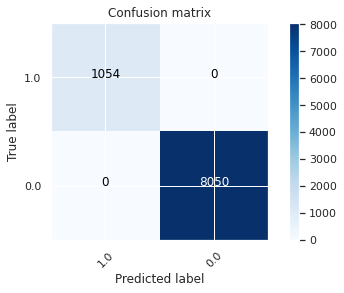

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("y_index")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

/content/spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


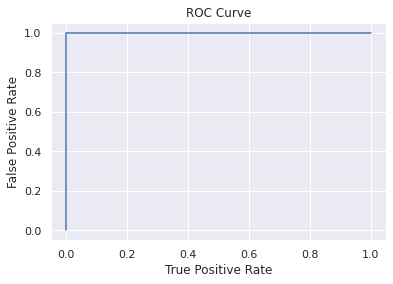

Training set areaUnderROC: 1.0


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
print("Coefficients: \n" + str(linearModelgen2.coefficientMatrix))
print("Intercept: " + str(linearModelgen2.interceptVector))

In [ ]:
predictions = linearModelgen.evaluate(logistictestdata)

testSummary = predictions

print(testSummary

In [ ]:
prtest = testSummary.pr.toPandas()
print(prtest['recall'])

In [ ]:
logisticdata.groupBy('y_index').count().orderBy('count',ascending=False).show()
#logisticdata.select("y_index").count()

In [ ]:
df_r.printSchema()

In [ ]:
df_r.select('campaign').toPandas().plot(style='.')

In [ ]:
df_r.select('previous').toPandas().plot(style='.')

In [ ]:
bank_df.select('previous').toPandas().plot(style='.')

In [ ]:
#from pyspark.sql import function as F
udf1 = F.udf(lambda x : int(x[0]),IntegerType())
df_r.select('balance_scaled',udf1('balance_scaled')).toPandas().plot(style='.')

In [ ]:
df_r.select('balance').toPandas().plot(style='.')

# see if binned campaign is better or not and also if we want onehot encoding and also we want to scale all numerical variables 

In [ ]:
df_r.groupby('campaign_binned').agg(min('campaign'), max('campaign')).orderBy('campaign_binned', ascending =True).show()

In [ ]:
df_r.groupBy('campaign_binned').count().orderBy('count',ascending=False).show()